In [ ]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import numpy as np
import seaborn as sns
import pandas as pd
from brokenaxes import brokenaxes
import sys
import os
import math
sys.path.append('..')
sys.path.append('../interlacer')
sys.path.append('..')
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import interlacer.utils as utils
import interlacer.layers as layers
import interlacer.models as models
import scripts.training_config as training_config
import interlacer.data_generator as data_generator
import interlacer.fastmri_data_generator as fastmri_data_generator
import interlacer.losses as losses
import scripts.filepaths as filepaths
import visualization_lib
import warnings
font_size=32
plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.family':'sans-serif'})
%matplotlib inline

In [ ]:
img_test = data_generator.get_mri_TEST_images()

In [ ]:
n = 320
base_dir = filepaths.TRAIN_DIR

def get_model_MAE(exp_name,exp_str,run_name,m_input,m_output):
    exp_dir = base_dir+exp_name  
    config_path = base_dir + exp_name + '/' + run_name + '/' + run_name+'_config.ini'
    model_path = base_dir + exp_name + '/' + run_name
    exp_config = training_config.TrainingConfig(config_path)
    exp_config.read_config()
    
    exp_config, model = visualization_lib.load_model(config_path)
    best_epoch = visualization_lib.get_best_ckpt(model_path)
    if(exp_config.task=='motion' and (exp_config.corruption_frac==0.01 or exp_config.corruption_frac==0.03) and exp_config.input_domain=='IMAGE'):
        best_epoch=5
    ckptname = 'cp-'+str(best_epoch).zfill(4)+'.ckpt'

    used_loss = losses.comp_image_loss(exp_config.output_domain,exp_config.loss) 
    fourier_l1 = losses.fourier_loss(exp_config.output_domain,'L1')
    fourier_l2 = losses.fourier_loss(exp_config.output_domain,'L2')
    image_l1 = losses.image_loss(exp_config.output_domain,'L1')
    image_l2 = losses.image_loss(exp_config.output_domain,'L2')
    ssim = losses.ssim(exp_config.output_domain)
    psnr = losses.psnr(exp_config.output_domain)

    model.compile(optimizer=keras.optimizers.Adam(),
        loss=used_loss,
        metrics=[ssim,fourier_l1,fourier_l2,image_l1,image_l2])
    model.load_weights(os.path.join(model_path,ckptname))

    if(exp_config.output_domain=='IMAGE'):
        m_input = utils.convert_tensor_to_image_domain(m_input)
        m_output = utils.convert_tensor_to_image_domain(m_output)
    
    maes = []
    for i in range(96):
        m_input_i = tf.expand_dims(m_input[i,:,:,:],0)
        m_output_i = tf.expand_dims(m_output[i,:,:,:],0)
        maes.append(model.evaluate(m_input_i,m_output_i,verbose=0)[0])
        
    return maes   

In [ ]:
def rename_architecture(architecture,input_domain):
    if(architecture=='CONV'):
        return('IMAGE')
    elif(architecture=='CONV_RESIDUAL'):
        if(input_domain=='FREQ'):
            return('FREQ')
        elif(input_domain=='IMAGE'):
            return('IMAGE')
    elif(architecture=='INTERLACER_RESIDUAL'):
        return('JOINT')
    elif(architecture=='ALTERNATING_RESIDUAL'):
        return('ALTERNATING')

In [4]:
data_folder = 'summary_data_cvpr_comp_img/'

In [ ]:

if not(os.path.exists(data_folder)):
    os.makedirs(data_folder)
for to_run in ['motion']:
    if(to_run=='undersample'):
        task = 'undersample'
        exp_name = 'brain_undersample_imagecomploss'
        architectures = ['ALTERNATING_RESIDUAL','INTERLACER_RESIDUAL','CONV_RESIDUAL','CONV_RESIDUAL']
        corruption_fracs = ['0.66','0.75','0.9']
    elif(to_run=='motion'):
        task = 'motion'
        exp_name = 'brain_motion_imagecomploss'
        architectures = ['ALTERNATING_RESIDUAL','INTERLACER_RESIDUAL','CONV_RESIDUAL','CONV_RESIDUAL']
        corruption_fracs = ['0.01','0.03','0.05']
    elif(to_run=='denoise'):
        task = 'noise'
        exp_name = 'brain_denoise'
        architectures = ['ALTERNATING_RESIDUAL','INTERLACER_RESIDUAL','CONV_RESIDUAL','CONV_RESIDUAL']
        corruption_fracs = ['5000.0','10000.0','15000.0']
    print(task)
    num_layers = [8, 8, 16, 16]
    input_domains = ['FREQ','FREQ','FREQ','IMAGE']
    activations = ['3-piece','3-piece','3-piece','relu']

    results = pd.DataFrame(columns = ['architecture','corruption_frac','MAE'])

    for corruption_frac in corruption_fracs:
        if(task!='motion'):
            val_generator = data_generator.generate_data(img_test, task, 'FREQ', 'FREQ', float(corruption_frac), batch_size=96)
            m_input,m_output = next(val_generator)
        else:
            val_generator = data_generator.generate_data(img_test, task, 'FREQ', 'FREQ', float(corruption_frac), batch_size=8, split='test')
            m_inputs = []
            m_outputs = []
            for i in range(12):
                m_input,m_output = next(val_generator)
                m_inputs.append(m_input)
                m_outputs.append(m_output)
            m_input = np.concatenate(m_inputs,axis=0)
            m_output = np.concatenate(m_outputs,axis=0)

        for i in range(4):
            loss_type = 'image'
            if(task=='motion' or task=='undersample'):
                loss_type = 'compimage'
            architecture = architectures[i]
            input_domain = input_domains[i]
            num_layer = num_layers[i]
            activation = activations[i]

            run_name = 'MRI-'+task+'-'+str(corruption_frac)+'-'+architecture+'-9-32-'+str(num_layer)+'-'+loss_type+'-L1-0.1-'+input_domain+'-'+input_domain+'-'+activation+'-5000-8'

            mae = get_model_MAE(exp_name,task,run_name,m_input,m_output)
            mae_df = pd.DataFrame(mae,columns=['MAE'])
            mae_df['architecture'] = rename_architecture(architecture,input_domain)
            mae_df['corruption_frac'] = corruption_frac

            results = results.append(mae_df,ignore_index=True)
        print('----')
    results.to_csv(data_folder+to_run+'_val.csv')
        


In [ ]:
for to_run in ['knee_undersample']:
    task = 'undersample'
    exp_name = 'knee_archcomparison'
    architectures = ['ALTERNATING_RESIDUAL','INTERLACER_RESIDUAL','CONV_RESIDUAL','CONV_RESIDUAL']
    corruption_fracs = ['0.75','0.875']
    print(task)
    num_layers = [8, 8, 16, 16]
    input_domains = ['FREQ','FREQ','FREQ','IMAGE']
    activations = ['3-piece','3-piece','3-piece','relu']

    results = pd.DataFrame(columns = ['architecture','corruption_frac','MAE'])

    for corruption_frac in corruption_fracs:
        fastmri_dir = filepaths.FASTMRI_DATA_DIR
        test_slice_dir = os.path.join(fastmri_dir, 'validate/singlecoil_val')
        print(test_slice_dir)
        val_generator = fastmri_data_generator.generate_data(test_slice_dir, task, 'FREQ', 'FREQ', float(corruption_frac), batch_size=96)
        m_input,m_output = next(val_generator)

        for i in range(4):
            loss_type = 'joint'
            architecture = architectures[i]
            input_domain = input_domains[i]
            num_layer = num_layers[i]
            activation = activations[i]

            run_name = 'FASTMRI-'+task+'-'+str(corruption_frac)+'-'+architecture+'-9-32-'+str(num_layer)+'-'+loss_type+'-L1-0.1-'+input_domain+'-'+input_domain+'-'+activation+'-5000-8'


            mae = get_model_MAE(exp_name,task,run_name,m_input,m_output)
            mae_df = pd.DataFrame(mae,columns=['MAE'])
            mae_df['architecture'] = rename_architecture(architecture,input_domain)
            mae_df['corruption_frac'] = corruption_frac

            results = results.append(mae_df,ignore_index=True)
        print('----')
    results.to_csv(data_folder+to_run+'_val.csv')
        


In [5]:
motion_results = pd.read_csv(data_folder+'motion_val.csv')
denoise_results = pd.read_csv(data_folder+'denoise_val.csv')
undersample_results = pd.read_csv(data_folder+'undersample_val.csv')
knee_undersample_results = pd.read_csv(data_folder+'knee_undersample_val.csv')

undersample_results['corruption_frac']=np.round(1-undersample_results['corruption_frac'],2)
knee_undersample_results['corruption_frac']=np.round(1-knee_undersample_results['corruption_frac'],2)

In [6]:
results_list = [undersample_results,motion_results,denoise_results,knee_undersample_results]


In [7]:
for df in results_list:
    df.replace(to_replace='ALTERNATING', value='Alternating', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='JOINT', value='Interleaved', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='IMAGE', value='Image', inplace=True, limit=None, regex=False, method='pad')
    df.replace(to_replace='FREQ', value='Frequency', inplace=True, limit=None, regex=False, method='pad')

In [ ]:
colors = ['#5900b3','#d499ff','#ff9999','#99d6ff']
this_cmap = sns.color_palette(colors,len(colors))
hue_order = ['Interleaved','Alternating','Frequency','Image']

fig,axes = plt.subplots(1,4,figsize=(20,5))
tasks = ['undersample','motion','noise','knee_undersample']
titles = ['a. Brain Undersampling','b. Brain Motion Corruption','c. Brain Noise Corruption','d. Knee Undersampling']
corruption_fracs_list = [[0.34,0.25,0.10],[0.01,0.03,0.05],[5000.0,10000.0,15000.0],[0.25,0.12]]

for i in range(4):    
    ax = axes[i]
    results_i = results_list[i]
    corruption_frac_i = corruption_fracs_list[i]
    task = tasks[i]
    if(task=='motion'):
        xlabel = r'$\gamma_{m}$'
    elif(task=='undersample' or task=='knee_undersample'):
        xlabel = r'$\gamma_{s}$'
    elif(task=='noise'):
        xlabel = r'$\gamma_{n}$'
    bp = sns.barplot(x='corruption_frac',y='MAE',order=corruption_frac_i,hue='architecture',data=results_i,palette=this_cmap,hue_order=hue_order,ci='sd',ax=ax)
    ax.set_xlabel(xlabel,fontsize=16)
    if(i==0):
        ax.set_ylabel('Mean Absolute Error',fontsize=16)
        ax.get_legend().set_title('') 
        plt.setp(ax.get_legend().get_texts(), fontsize='16')
    else:
        ax.set_ylabel('')
        bp.legend_.remove()   
       
    ax.set_ylim(bottom=0)    
    ax.set_title(titles[i],fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize=16)



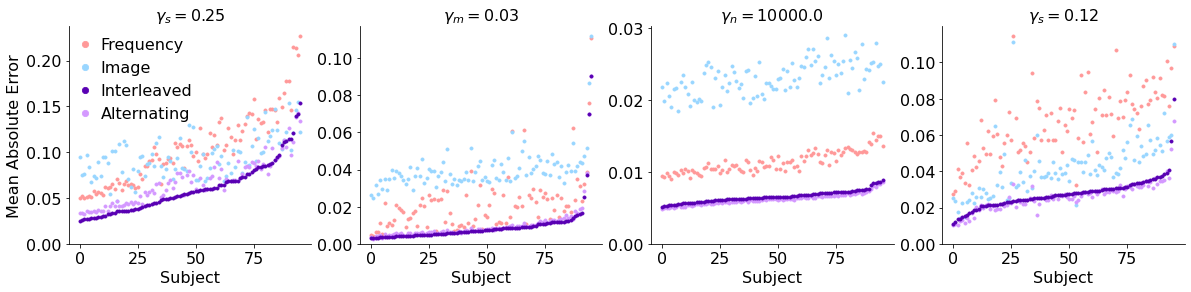

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    colors = ['#ff9999','#99d6ff','#d499ff','#5900b3']
    this_cmap = sns.color_palette(colors,len(colors))
    hue_order = ['Frequency','Image','Alternating','Interleaved']
    sns.set_palette(this_cmap)
    fig,axes = plt.subplots(1,4,figsize=(20,4))
    for i in range(4):    
        ax = axes[i]
        
        #if(i==3):
            #ax.axis('off')
            #break
        results_i = results_list[i]
        corruption_frac_i = corruption_fracs_list[i]
        task = tasks[i]

        if(i<3): cf = corruption_frac_i[1]
        if(i==3): cf = 0.12

        if(task=='motion'):
            xlabel = r'$\gamma_{m} = $'+str(cf)
        elif(task=='undersample' or task=='knee_undersample'):
            xlabel = r'$\gamma_{s} = $'+str(cf)
        elif(task=='noise'):
            xlabel = r'$\gamma_{n} = $'+str(cf)
            
        results_mid = results_i[results_i['corruption_frac']==cf]
        results_mid['index1']=results_mid.index
        results_mid['i']=results_mid.index1%96+96*(results_mid.index1/384).astype('int')

        results_mid.set_index('i')
        results_mid = results_mid.pivot(index='i', columns='architecture')['MAE']
        
        results_sorted = results_mid.sort_values('Interleaved')
        
        l=96
        sns.scatterplot(range(l),results_sorted['Frequency'],label='Frequency',ax=ax,edgecolor=None,s=10)
        sns.scatterplot(range(l),results_sorted['Image'],label='Image',ax=ax,edgecolor=None,s=10)
        sns.scatterplot(range(l),results_sorted['Alternating'],label='Alternating',ax=ax,edgecolor=None,s=10)
        sp = sns.scatterplot(range(l),results_sorted['Interleaved'],label='Interleaved',ax=ax, palette=this_cmap,hue_order=hue_order,edgecolor=None,s=10)
        
        ax.set_xlabel('Subject',fontsize=16)

        if(i==0):
            ax.set_ylabel('Mean Absolute Error',fontsize=16)
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().set_title('') 
            
            handles = [handles[i] for i in [0,1,3,2]]
            labels = [labels[i] for i in [0,1,3,2]]

            ax.legend(handles,labels,fontsize=16,framealpha=0.0,handletextpad=0.,bbox_to_anchor=(0.07, 0.5, 0.5, 0.3),markerscale=2)
        else:
            ax.set_ylabel('')
            sp.legend_.remove()


        ax.set_ylim(bottom=0)
        ax.set_title(xlabel,fontsize=16)#titles[i]+'\n'+
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(labelsize=16)

        
plt.savefig('subjectwise_comparison_1.pdf',bbox_inches='tight')